In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
import numpy as np

class GridEnvironment:
    def __init__(self, rows, cols):
        """
        Initialize the grid environment.
        :param rows: Number of rows in the grid.
        :param cols: Number of columns in the grid.
        """
        self.rows = rows
        self.cols = cols
        self.grid = np.zeros((rows, cols), dtype=int)  # 0: Free space

    def add_static_obstacles(self, obstacle_positions):
        """
        Add static obstacles to the grid.
        :param obstacle_positions: List of (row, col) tuples for static obstacles.
        """
        for row, col in obstacle_positions:
            if self.is_valid_cell(row, col):
                self.grid[row, col] = 1  # 1: Static obstacle

    def add_dynamic_obstacles(self, obstacle_positions):
        """
        Add dynamic obstacles to the grid.
        :param obstacle_positions: List of (row, col) tuples for dynamic obstacles.
        """
        for row, col in obstacle_positions:
            if self.is_valid_cell(row, col):
                self.grid[row, col] = 2  # 2: Dynamic obstacle

    def update_dynamic_obstacles(self, new_positions):
        """
        Update positions of dynamic obstacles in the grid.
        :param new_positions: List of (row, col) tuples for new dynamic obstacle positions.
        """
        # Clear previous dynamic obstacles
        self.grid[self.grid == 2] = 0
        # Set new dynamic obstacle positions
        self.add_dynamic_obstacles(new_positions)

    def is_valid_cell(self, row, col):
        """
        Check if a cell is within bounds and not a static obstacle.
        :param row: Row index.
        :param col: Column index.
        :return: True if valid, False otherwise.
        """
        return 0 <= row < self.rows and 0 <= col < self.cols and self.grid[row, col] != 1

    def display(self):
        """
        Display the grid in a readable format.
        """
        print("Grid Layout:")
        for row in self.grid:
            print(" ".join(map(str, row)))

# Example Usage
if __name__ == "__main__":
    # Initialize a 10x10 grid
    grid_env = GridEnvironment(10, 10)

    # Add static obstacles
    static_obstacles = [(3, 4), (3, 5), (3, 6), (6, 2), (6, 3)]
    grid_env.add_static_obstacles(static_obstacles)

    # Add dynamic obstacles
    dynamic_obstacles = [(4, 4), (5, 5)]
    grid_env.add_dynamic_obstacles(dynamic_obstacles)

    # Display initial grid
    print("Initial Grid:")
    grid_env.display()

    # Update dynamic obstacles
    new_dynamic_obstacles = [(4, 5), (5, 6)]
    grid_env.update_dynamic_obstacles(new_dynamic_obstacles)

    # Display updated grid
    print("\nUpdated Grid:")
    grid_env.display()


Initial Grid:
Grid Layout:
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 1 1 1 0 0 0
0 0 0 0 2 0 0 0 0 0
0 0 0 0 0 2 0 0 0 0
0 0 1 1 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0

Updated Grid:
Grid Layout:
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 1 1 1 0 0 0
0 0 0 0 0 2 0 0 0 0
0 0 0 0 0 0 2 0 0 0
0 0 1 1 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0


In [19]:
class PrioritizedPlanner:
    def __init__(self, grid):
        """
        Initialize the prioritized planner.
        :param grid: 2D numpy array representing the environment grid.
        """
        self.grid = grid
        self.rows, self.cols = grid.shape
        self.reserved_cells = set()  # Reserved cells for current planning

    def manhattan_distance(self, start, goal):
        """
        Compute Manhattan distance between two points.
        :param start: (row, col) tuple of the starting point.
        :param goal: (row, col) tuple of the goal point.
        :return: Manhattan distance.
        """
        return abs(start[0] - goal[0]) + abs(start[1] - goal[1])

    def a_star(self, start, goal, reserved_cells):
        """
        A* pathfinding algorithm.
        :param start: (row, col) tuple of the starting point.
        :param goal: (row, col) tuple of the goal point.
        :param reserved_cells: Set of cells reserved by higher-priority agents.
        :return: List of (row, col) tuples representing the path.
        """
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        open_list = []
        heapq.heappush(open_list, (0, start))
        came_from = {}
        cost_so_far = {start: 0}

        while open_list:
            _, current = heapq.heappop(open_list)

            if current == goal:
                break

            for dx, dy in directions:
                neighbor = (current[0] + dx, current[1] + dy)
                if (0 <= neighbor[0] < self.rows and 0 <= neighbor[1] < self.cols and
                        self.grid[neighbor[0], neighbor[1]] == 0 and neighbor not in reserved_cells):
                    new_cost = cost_so_far[current] + 1
                    if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
                        cost_so_far[neighbor] = new_cost
                        priority = new_cost + self.manhattan_distance(neighbor, goal)
                        heapq.heappush(open_list, (priority, neighbor))
                        came_from[neighbor] = current

        # Reconstruct path
        path = []
        current = goal
        while current != start:
            path.append(current)
            current = came_from.get(current)
            if current is None:  # If no path found
                return []
        path.append(start)
        path.reverse()
        return path

    def plan_paths(self, agents, goal):
        """
        Plan paths for all agents sequentially based on priority.
        :param agents: List of (row, col) tuples representing agent starting positions.
        :param goal: (row, col) tuple of the goal point.
        :return: List of paths for each agent.
        """
        # Assign priorities based on Manhattan distance to the goal
        agents_sorted = sorted(agents, key=lambda a: self.manhattan_distance(a, goal))
        paths = []
        reserved_cells = set()

        for agent in agents_sorted:
            path = self.a_star(agent, goal, reserved_cells)
            if path:
                paths.append(path)
                # Reserve cells for the current path (excluding the goal)
                reserved_cells.update(path[:-1])
            else:
                paths.append([])  # No valid path found

        return paths

# Example Usage
if __name__ == "__main__":
    # Define a 10x10 grid (0: free, 1: static obstacle)
    grid = np.zeros((10, 10))
    grid[3, 4:7] = 1  # Static obstacle
    grid[6, 2:4] = 1  # Static obstacle

    # Initialize agents and goal
    agents = [(0, 0), (9, 0), (0, 9)]  # Starting positions of agents
    goal = (7, 7)  # Goal position

    # Initialize planner and plan paths
    planner = PrioritizedPlanner(grid)
    paths = planner.plan_paths(agents, goal)

    # Output paths
    for i, path in enumerate(paths):
        print(f"Agent {i + 1} path: {path}")


Agent 1 path: [(9, 0), (8, 0), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7)]
Agent 2 path: [(0, 9), (0, 8), (0, 7), (1, 7), (2, 7), (3, 7), (4, 7), (5, 7), (6, 7), (7, 7)]
Agent 3 path: []


In [20]:
import heapq
import numpy as np

class CollisionAvoidancePlanner:
    def __init__(self, grid):
        """
        Initialize the collision avoidance planner.
        :param grid: 2D numpy array representing the environment grid.
        """
        self.grid = grid
        self.rows, self.cols = grid.shape

    def manhattan_distance(self, start, goal):
        """
        Compute Manhattan distance between two points.
        :param start: (row, col) tuple of the starting point.
        :param goal: (row, col) tuple of the goal point.
        :return: Manhattan distance.
        """
        return abs(start[0] - goal[0]) + abs(start[1] - goal[1])

    def a_star(self, start, goal, reserved_cells):
        """
        A* pathfinding algorithm.
        :param start: (row, col) tuple of the starting point.
        :param goal: (row, col) tuple of the goal point.
        :param reserved_cells: Dictionary of reserved cells {cell: time_step}.
        :return: List of (row, col) tuples representing the path.
        """
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        open_list = []
        heapq.heappush(open_list, (0, 0, start))
        came_from = {}
        cost_so_far = {start: 0}

        while open_list:
            _, time_step, current = heapq.heappop(open_list)

            if current == goal:
                break

            for dx, dy in directions:
                neighbor = (current[0] + dx, current[1] + dy)
                if (0 <= neighbor[0] < self.rows and 0 <= neighbor[1] < self.cols and
                        self.grid[neighbor[0], neighbor[1]] == 0 and 
                        reserved_cells.get((neighbor, time_step + 1), False) is False):
                    new_cost = cost_so_far[current] + 1
                    if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
                        cost_so_far[neighbor] = new_cost
                        priority = new_cost + self.manhattan_distance(neighbor, goal)
                        heapq.heappush(open_list, (priority, time_step + 1, neighbor))
                        came_from[(neighbor, time_step + 1)] = (current, time_step)

        # Reconstruct path
        path = []
        current = goal
        while (current, time_step) in came_from:
            path.append(current)
            current, time_step = came_from[(current, time_step)]
        path.reverse()
        return path

    def plan_paths(self, agents, goal):
        """
        Plan paths for all agents with collision avoidance.
        :param agents: List of (row, col) tuples representing agent starting positions.
        :param goal: (row, col) tuple of the goal point.
        :return: List of paths for each agent.
        """
        reserved_cells = {}
        paths = []

        for agent in agents:
            path = self.a_star(agent, goal, reserved_cells)
            if path:
                paths.append(path)
                # Reserve cells with time steps
                for t, cell in enumerate(path):
                    reserved_cells[(cell, t)] = True
            else:
                paths.append([])  # No valid path found

        return paths

# Example Usage
if __name__ == "__main__":
    # Define a 10x10 grid (0: free, 1: static obstacle)
    grid = np.zeros((10, 10))
    grid[3, 4:7] = 1  # Static obstacle
    grid[6, 2:4] = 1  # Static obstacle

    # Initialize agents and goal
    agents = [(9, 0), (0, 9), (0, 0)]  # Starting positions of agents
    goal = (7, 7)  # Goal position

    # Initialize planner and plan paths
    planner = CollisionAvoidancePlanner(grid)
    paths = planner.plan_paths(agents, goal)

    # Output paths
    for i, path in enumerate(paths):
        print(f"Agent {i + 1} path: {path}")


Agent 1 path: [(8, 0), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7)]
Agent 2 path: [(0, 8), (0, 7), (1, 7), (2, 7), (3, 7), (4, 7), (5, 7), (6, 7), (7, 7)]
Agent 3 path: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 7), (2, 7), (3, 7), (4, 7), (5, 7), (6, 7), (7, 7)]


Testing: Obstacles=5, Agents=1
Agent 1 path found: [(2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]


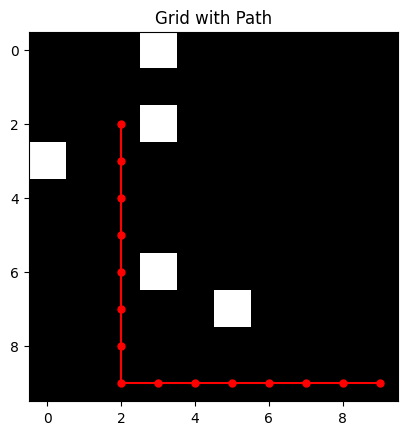

Testing: Obstacles=5, Agents=3
Agent 1 path found: [(8, 6), (9, 6), (9, 7), (9, 8), (9, 9)]
Agent 2 path found: [(4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]
Agent 3 path found: [(2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8), (8, 8), (9, 8), (9, 9)]


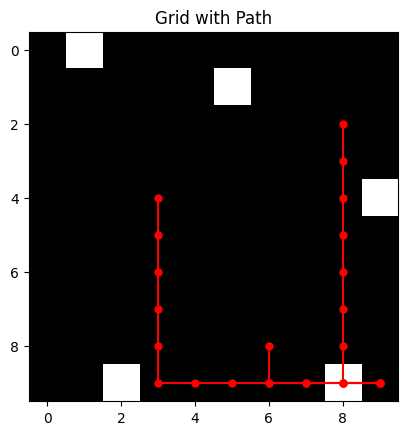

Testing: Obstacles=5, Agents=5
Agent 1 path found: [(4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]
Agent 2 path found: [(6, 3), (7, 3), (8, 3), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]
Agent 3 path found: [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]
Agent 4 path found: [(6, 5), (7, 5), (8, 5), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]
Agent 5 path found: [(3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]


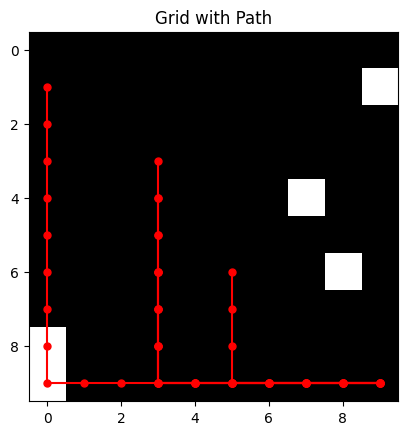

Testing: Obstacles=20, Agents=1
Agent 1 path found: [(2, 4), (3, 4), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]


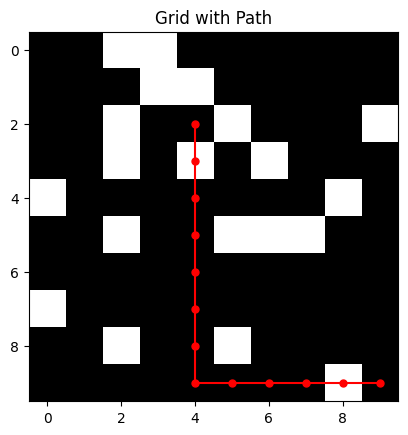

Testing: Obstacles=20, Agents=3
Agent 1 path found: [(1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (8, 6), (9, 6), (9, 7), (9, 8), (9, 9)]
Agent 2 path found: [(7, 9), (8, 9), (9, 9)]
Agent 3 path found: [(6, 7), (7, 7), (8, 7), (9, 7), (9, 8), (9, 9)]


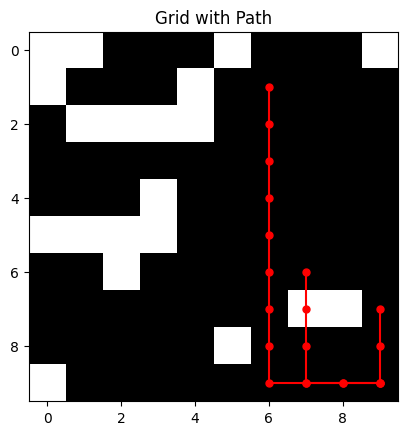

Testing: Obstacles=20, Agents=5
Agent 1 path found: [(8, 6), (9, 6), (9, 7), (9, 8), (9, 9)]
Agent 2 path found: [(6, 7), (7, 7), (8, 7), (9, 7), (9, 8), (9, 9)]
Agent 3 path found: [(1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]
Agent 4 path found: [(1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]
Agent 5 path found: [(9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]


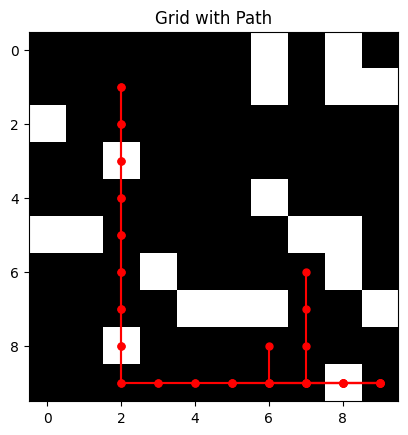

Testing: Obstacles=50, Agents=1
Agent 1 path found: [(5, 4), (6, 4), (7, 4), (8, 4), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]


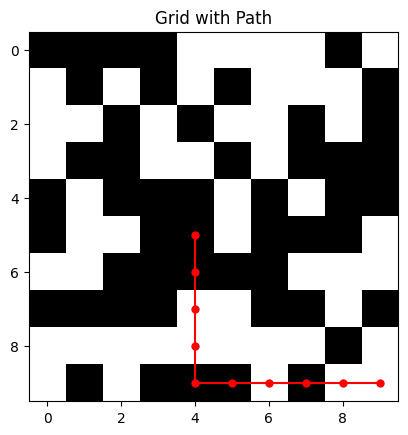

Testing: Obstacles=50, Agents=3
Agent 1 path found: [(1, 5), (2, 5), (3, 5), (4, 5), (5, 5), (6, 5), (7, 5), (8, 5), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]
Agent 2 path found: [(8, 1), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]
Agent 3 path found: [(8, 9), (9, 9)]


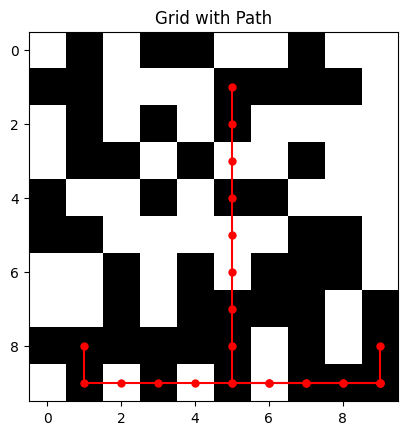

Testing: Obstacles=50, Agents=5
Agent 1 path found: [(1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]
Agent 2 path found: [(9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]
Agent 3 path found: [(4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]
Agent 4 path found: [(0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]
Agent 5 path found: [(2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]


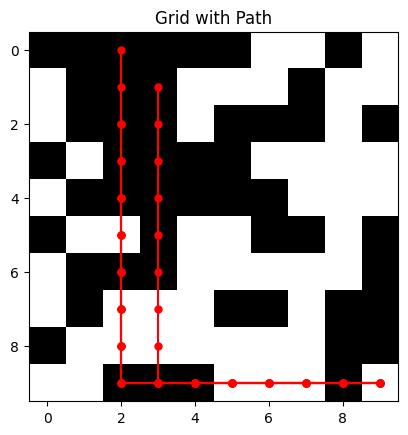

In [23]:
import numpy as np
import random
import matplotlib.pyplot as plt

class PathPlannerTest:
    def __init__(self, grid_size=(10, 10)):
        self.grid_size = grid_size
        self.grid = np.zeros(grid_size)
        
    def generate_random_obstacles(self, num_obstacles):
        """
        Randomly place static obstacles on the grid.
        :param num_obstacles: The number of obstacles to place.
        """
        obstacles = 0
        while obstacles < num_obstacles:
            r, c = random.randint(0, self.grid_size[0]-1), random.randint(0, self.grid_size[1]-1)
            if self.grid[r, c] == 0:  # Ensure the cell is not already an obstacle
                self.grid[r, c] = 1
                obstacles += 1

    def generate_agents(self, num_agents):
        """
        Randomly generate agents' starting positions.
        :param num_agents: The number of agents to generate.
        :return: List of agents' starting positions.
        """
        agents = []
        while len(agents) < num_agents:
            r, c = random.randint(0, self.grid_size[0]-1), random.randint(0, self.grid_size[1]-1)
            if self.grid[r, c] == 0:  # Ensure the cell is free
                agents.append((r, c))
        return agents

    def plot_grid(self, paths=None):
        """
        Plot the grid and paths for visualization.
        :param paths: List of agent paths, if provided.
        """
        plt.imshow(self.grid, cmap='gray', origin='upper')
        if paths:
            for path in paths:
                path_r, path_c = zip(*path)
                plt.plot(path_c, path_r, marker='o', color='r', linestyle='-', markersize=5)
        plt.title("Grid with Path")
        plt.show()

    def run_tests(self, num_obstacles_list, num_agents_list, goal=(9, 9)):
        """
        Run pathfinding tests on various environments.
        :param num_obstacles_list: List of different numbers of obstacles to test.
        :param num_agents_list: List of different numbers of agents to test.
        :param goal: Goal position for all agents.
        """
        for num_obstacles in num_obstacles_list:
            for num_agents in num_agents_list:
                self.grid.fill(0)  # Reset grid
                self.generate_random_obstacles(num_obstacles)
                agents = self.generate_agents(num_agents)
                
                print(f"Testing: Obstacles={num_obstacles}, Agents={num_agents}")
                self.evaluate_pathfinding(agents, goal)

    def evaluate_pathfinding(self, agents, goal):
        """
        Evaluate pathfinding for the given agents and goal.
        :param agents: List of agents' starting positions.
        :param goal: The goal position for all agents.
        """
        # Example pathfinding function (you should replace this with your actual path planner)
        paths = self.plan_paths(agents, goal)
        
        # Check if paths were found for all agents
        for i, path in enumerate(paths):
            if path:
                print(f"Agent {i + 1} path found: {path}")
            else:
                print(f"Agent {i + 1} could not find a path.")
        
        # Visualize the grid and paths
        self.plot_grid(paths)

    def plan_paths(self, agents, goal):
        """
        Simple placeholder pathfinding function (replace with actual planner).
        :param agents: List of agents' starting positions.
        :param goal: The goal position.
        :return: List of paths for each agent.
        """
        # Here we just return random paths for demonstration (replace with your actual path planner)
        paths = []
        for agent in agents:
            path = [agent]
            while path[-1] != goal:
                r, c = path[-1]
                if r < goal[0]:
                    r += 1
                elif r > goal[0]:
                    r -= 1
                elif c < goal[1]:
                    c += 1
                elif c > goal[1]:
                    c -= 1
                path.append((r, c))
            paths.append(path)
        return paths

# Example Usage
if __name__ == "__main__":
    # Initialize test planner
    test_planner = PathPlannerTest(grid_size=(10, 10))

    # Define different test scenarios
    num_obstacles_list = [5, 20, 50]  # Sparse, moderate, dense obstacles
    num_agents_list = [1, 3, 5]  # Varying number of agents

    # Run tests
    test_planner.run_tests(num_obstacles_list, num_agents_list)


Testing: Obstacles=5, Agents=1
Agent 1 path found: [(8, 8), (8, 9), (9, 9)]


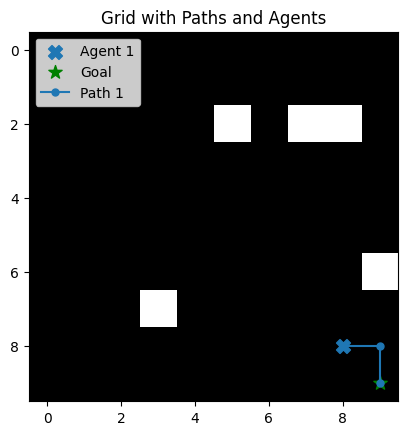

Testing: Obstacles=5, Agents=3
Agent 1 path found: [(7, 8), (8, 8), (8, 9), (9, 9)]


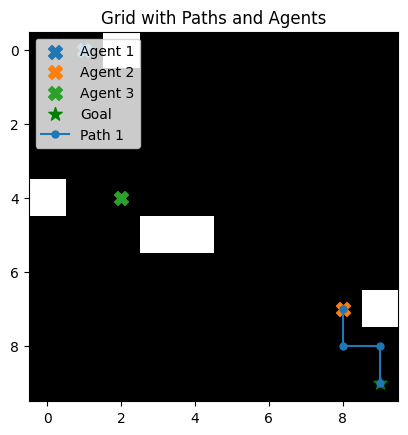

Testing: Obstacles=5, Agents=5
Agent 1 path found: [(4, 6), (4, 7), (4, 8), (5, 8), (6, 8), (7, 8), (7, 9), (8, 9), (9, 9)]


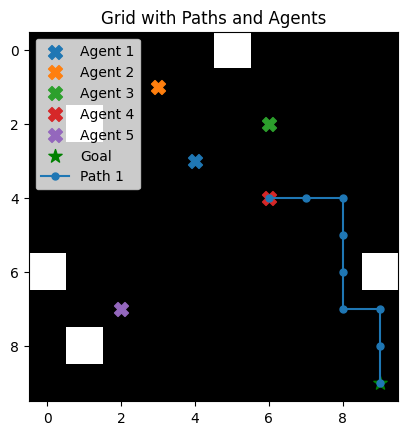

Testing: Obstacles=10, Agents=1
Agent 1 path found: [(5, 7), (5, 8), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9)]


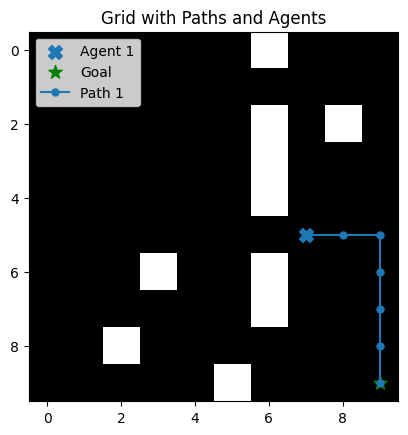

Testing: Obstacles=10, Agents=3
Agent 1 path found: [(9, 9)]


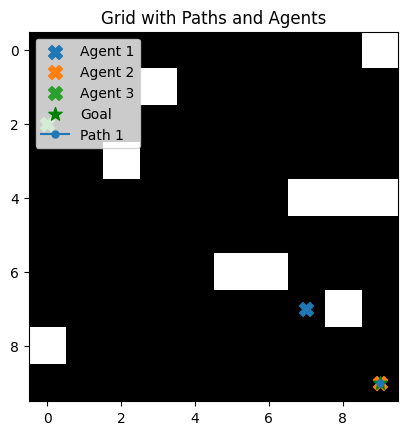

Testing: Obstacles=10, Agents=5
Agent 1 path found: [(7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (8, 9), (9, 9)]


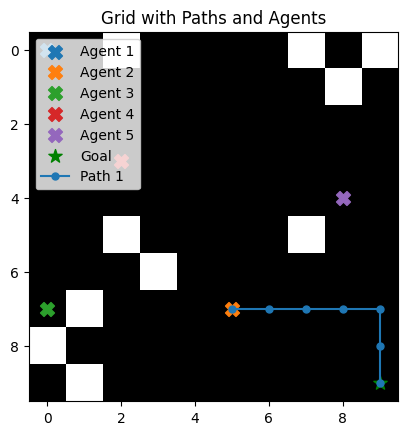

Testing: Obstacles=20, Agents=1
Agent 1 path found: [(6, 0), (6, 1), (6, 2), (6, 3), (7, 3), (8, 3), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]


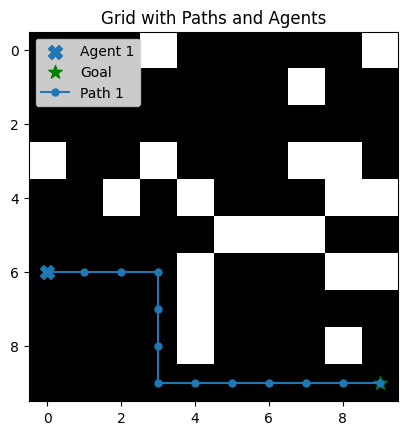

Testing: Obstacles=20, Agents=3
Agent 1 path found: [(8, 6), (8, 7), (9, 7), (9, 8), (9, 9)]


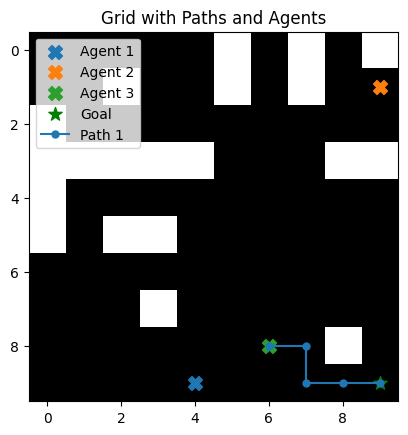

Testing: Obstacles=20, Agents=5
Agent 1 path found: [(5, 6), (5, 7), (5, 8), (6, 8), (7, 8), (8, 8), (9, 8), (9, 9)]


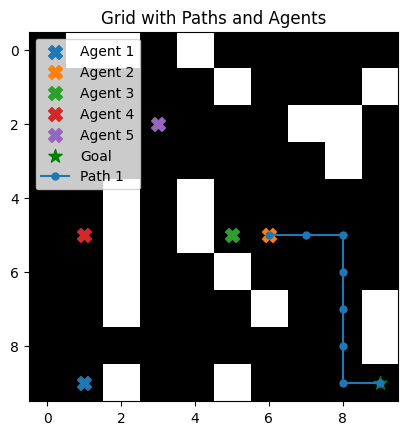

In [34]:
import numpy as np
import random
import heapq
import matplotlib.pyplot as plt

class PathPlannerTest:
    def __init__(self, grid_size=(10, 10)):
        self.grid_size = grid_size
        self.grid = np.zeros(grid_size)

    def generate_random_obstacles(self, num_obstacles, num_agents, goal):
        """
        Randomly place static obstacles on the grid, ensuring enough space for agents and the goal.
        At least one path should exist for any agent to reach the goal.
        :param num_obstacles: The number of obstacles to place.
        :param num_agents: The number of agents to consider.
        :param goal: The goal position.
        """
        free_cells = self.grid_size[0] * self.grid_size[1] - num_agents - 1  # Reserve one cell for the goal
        max_obstacles = free_cells // 2
        
        num_obstacles = min(num_obstacles, max_obstacles)
        
        obstacles = 0
        while obstacles < num_obstacles:
            r, c = random.randint(0, self.grid_size[0]-1), random.randint(0, self.grid_size[1]-1)
            if self.grid[r, c] == 0 and (r, c) != goal:
                self.grid[r, c] = 1
                obstacles += 1
        
        # Ensure at least one path to the goal exists for any agent
        if not self.check_path_to_goal(goal):
            self.adjust_obstacles_for_path(goal)

    def generate_random_obstacles(self, num_obstacles, num_agents, goal):
        """
        Randomly place static obstacles on the grid, ensuring enough space for agents and the goal.
        At least one path should exist for any agent to reach the goal.
        :param num_obstacles: The number of obstacles to place.
        :param num_agents: The number of agents to consider.
        :param goal: The goal position.
        """
        free_cells = self.grid_size[0] * self.grid_size[1] - num_agents - 1  # Reserve one cell for the goal
        max_obstacles = free_cells // 2
        
        num_obstacles = min(num_obstacles, max_obstacles)
        
        obstacles = 0
        while obstacles < num_obstacles:
            r, c = random.randint(0, self.grid_size[0]-1), random.randint(0, self.grid_size[1]-1)
            if self.grid[r, c] == 0 and (r, c) != goal:
                self.grid[r, c] = 1
                obstacles += 1
        
        # Ensure at least one path to the goal exists for any agent
        if not self.check_path_to_goal(goal):
            self.adjust_obstacles_for_path(goal)

    def check_path_to_goal(self, goal, agents=[]):
        """
        Check if there is a valid path to the goal using A* algorithm.
        :param goal: The goal position.
        :param agents: List of current agents' positions to avoid collisions.
        :return: True if a path exists, otherwise False.
        """
        start = (0, 0)  # You can modify this to any starting position
        return bool(self.a_star(start, goal, agents))  # Ensure agents list is passed


    def generate_agents(self, num_agents):
        """
        Randomly generate agents' starting positions, ensuring no overlap with obstacles or the goal.
        :param num_agents: The number of agents to generate.
        :return: List of agents' starting positions.
        """
        agents = []
        while len(agents) < num_agents:
            r, c = random.randint(0, self.grid_size[0]-1), random.randint(0, self.grid_size[1]-1)
            if self.grid[r, c] == 0:  # Ensure the cell is free
                agents.append((r, c))
        return agents

    def plot_grid(self, paths=None, agents=None, goal=None):
        """
        Plot the grid and paths for visualization.
        :param paths: List of agent paths, if provided.
        :param agents: List of agents' positions.
        :param goal: The goal position.
        """
        plt.imshow(self.grid, cmap='gray', origin='upper')

        # Visualize agents with different colors
        if agents:
            for i, agent in enumerate(agents):
                plt.scatter(agent[1], agent[0], color=plt.cm.tab10(i % 10), label=f'Agent {i + 1}', s=100, marker='X')

        # Visualize the goal position with a distinct color
        if goal:
            plt.scatter(goal[1], goal[0], color='green', label='Goal', s=100, marker='*')

        # Visualize the paths with different colors for each agent
        if paths:
            for i, path in enumerate(paths):
                if path:  # Only plot if path is not empty
                    path_r, path_c = zip(*path)
                    plt.plot(path_c, path_r, marker='o', color=plt.cm.tab10(i % 10), linestyle='-', markersize=5, label=f'Path {i + 1}')
        
        plt.title("Grid with Paths and Agents")
        plt.legend(loc='upper left')
        plt.show()

    def run_tests(self, num_obstacles_list, num_agents_list, goal=(9, 9)):
        """
        Run pathfinding tests on various environments.
        :param num_obstacles_list: List of different numbers of obstacles to test.
        :param num_agents_list: List of different numbers of agents to test.
        :param goal: Goal position for all agents.
        """
        for num_obstacles in num_obstacles_list:
            for num_agents in num_agents_list:
                self.grid.fill(0)  # Reset grid
                self.generate_random_obstacles(num_obstacles, num_agents, goal)
                agents = self.generate_agents(num_agents)
                
                print(f"Testing: Obstacles={num_obstacles}, Agents={num_agents}")
                self.evaluate_pathfinding(agents, goal)

    def evaluate_pathfinding(self, agents, goal):
        """
        Evaluate pathfinding for the given agents and goal.
        :param agents: List of agents' starting positions.
        :param goal: The goal position for all agents.
        """
        # Find which agent is closest to the goal
        closest_agent_idx = self.get_closest_agent(agents, goal)
        
        # Pathfinding for the closest agent
        paths = self.plan_paths([agents[closest_agent_idx]], goal)
        
        # Check if paths were found for all agents
        for i, path in enumerate(paths):
            if path:
                print(f"Agent {i + 1} path found: {path}")
            else:
                print(f"Agent {i + 1} could not find a path.")
        
        # Visualize the grid and paths
        self.plot_grid(paths, agents, goal)

    def get_closest_agent(self, agents, goal):
        """
        Find the agent closest to the goal based on Manhattan distance.
        :param agents: List of agents' starting positions.
        :param goal: The goal position.
        :return: Index of the closest agent.
        """
        distances = [self.manhattan_distance(agent, goal) for agent in agents]
        return np.argmin(distances)  # Return the index of the closest agent

    def plan_paths(self, agents, goal):
        """
        Plan paths using A* algorithm for each agent.
        :param agents: List of agents' starting positions.
        :param goal: The goal position.
        :return: List of paths for each agent.
        """
        paths = []
        for agent in agents:
            path = self.a_star(agent, goal, agents)  # Ensure agents don't collide
            paths.append(path)
        return paths

    def a_star(self, start, goal, agents):
        """
        A* pathfinding algorithm.
        :param start: (row, col) tuple of the starting point.
        :param goal: (row, col) tuple of the goal point.
        :param agents: List of all agents' current positions.
        :return: List of (row, col) tuples representing the path.
        """
        # Directions for moving in the grid (up, down, left, right)
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        
        # Initialize the open and closed lists for A*
        open_list = []
        heapq.heappush(open_list, (0 + self.manhattan_distance(start, goal), 0, start))
        came_from = {}
        g_cost = {start: 0}
        
        while open_list:
            _, cost, current = heapq.heappop(open_list)

            if current == goal:
                return self.reconstruct_path(came_from, current)
            
            for dx, dy in directions:
                neighbor = (current[0] + dx, current[1] + dy)
                
                # Check if the neighbor is valid (within bounds, not blocked, and not occupied by other agents)
                if 0 <= neighbor[0] < self.grid_size[0] and 0 <= neighbor[1] < self.grid_size[1] and self.grid[neighbor[0], neighbor[1]] == 0 and neighbor not in agents:
                    new_cost = g_cost[current] + 1
                    if neighbor not in g_cost or new_cost < g_cost[neighbor]:
                        g_cost[neighbor] = new_cost
                        priority = new_cost + self.manhattan_distance(neighbor, goal)
                        heapq.heappush(open_list, (priority, new_cost, neighbor))
                        came_from[neighbor] = current
        
        return []  # Return empty list if no path found

    def manhattan_distance(self, start, goal):
        """
        Compute Manhattan distance between two points.
        :param start: (row, col) tuple of the starting point.
        :param goal: (row, col) tuple of the goal point.
        :return: Manhattan distance.
        """
        return abs(start[0] - goal[0]) + abs(start[1] - goal[1])

    def reconstruct_path(self, came_from, current):
        """
        Reconstruct the path from the came_from dictionary.
        :param came_from: Dictionary of came_from points.
        :param current: The current point (goal point).
        :return: List of (row, col) tuples representing the reconstructed path.
        """
        path = [current]
        while current in came_from:
            current = came_from[current]
            path.append(current)
        path.reverse()
        return path


# Example Usage
if __name__ == "__main__":
    # Initialize test planner
    test_planner = PathPlannerTest(grid_size=(10, 10))

    # Define different test scenarios
    num_obstacles_list = [5, 10, 20]  # Sparse, moderate, dense obstacles
    num_agents_list = [1, 3, 5]  # Varying number of agents

    # Run tests
    test_planner.run_tests(num_obstacles_list, num_agents_list)


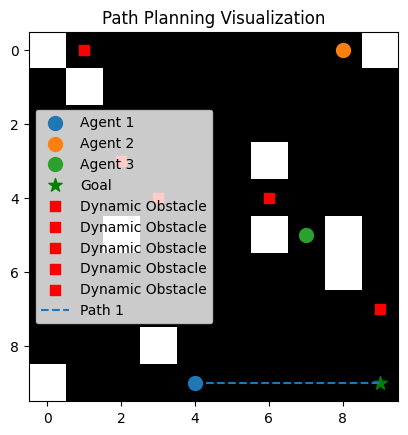

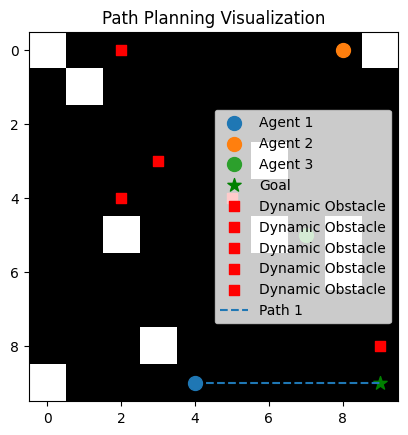

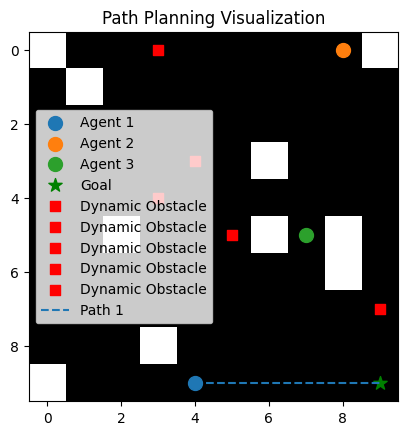

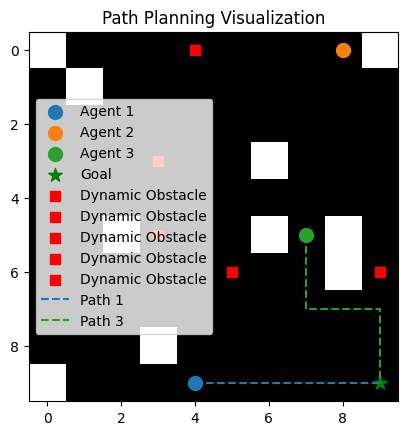

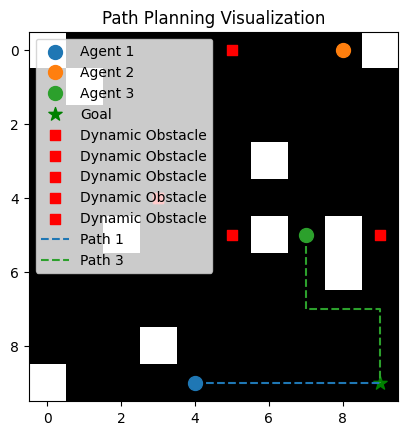

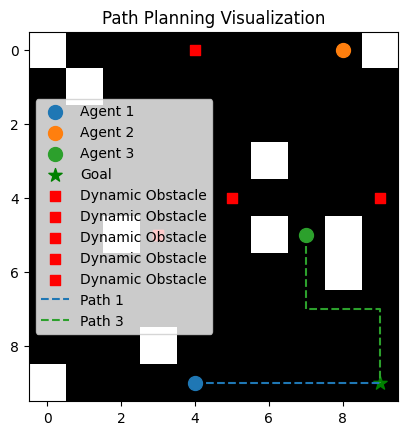

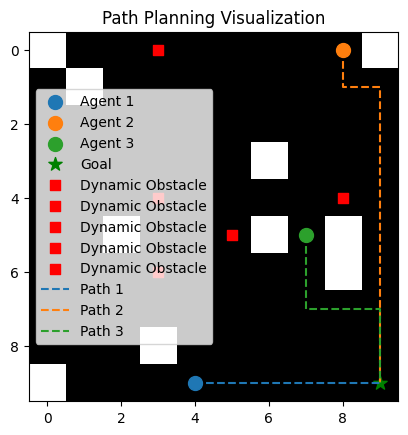

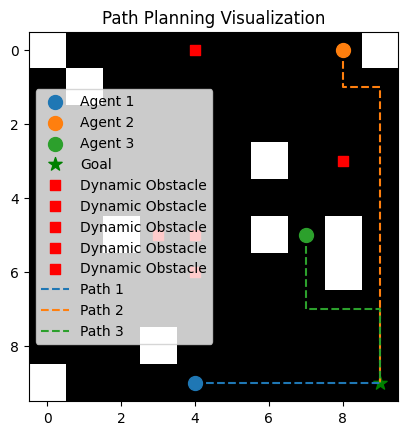

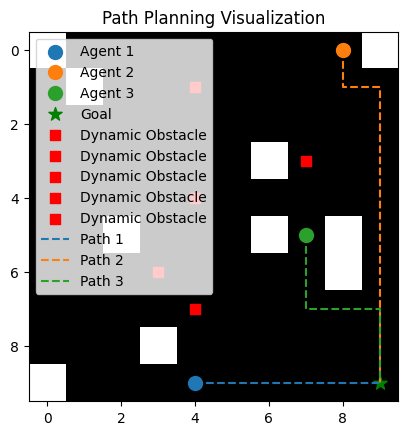

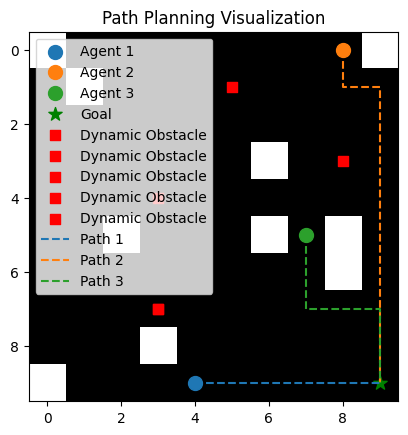

In [5]:
import numpy as np
import random
import heapq
import matplotlib.pyplot as plt

class PathPlannerTest:
    def __init__(self, grid_size=(10, 10)):
        self.grid_size = grid_size
        self.grid = np.zeros(grid_size)
        self.dynamic_obstacles = []

    def generate_dynamic_obstacles(self, num_dynamic_obstacles, goal):
        while len(self.dynamic_obstacles) < num_dynamic_obstacles:
            r, c = random.randint(0, self.grid_size[0] - 1), random.randint(0, self.grid_size[1] - 1)
            if self.grid[r, c] == 0 and (r, c) != goal:
                self.dynamic_obstacles.append((r, c))

    def update_dynamic_obstacles(self, agents, goal, min_distance=2):
        new_positions = []
        for r, c in self.dynamic_obstacles:
            valid_moves = []
            for dr, dc in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                new_r, new_c = r + dr, c + dc
                if (0 <= new_r < self.grid_size[0] and
                    0 <= new_c < self.grid_size[1] and
                    self.grid[new_r, new_c] == 0 and
                    (new_r, new_c) != goal and
                    all(self.manhattan_distance((new_r, new_c), agent) >= min_distance for agent in agents)):
                    valid_moves.append((new_r, new_c))

            if valid_moves:
                new_positions.append(random.choice(valid_moves))
            else:
                new_positions.append((r, c))
        self.dynamic_obstacles = new_positions

    def generate_static_obstacles(self, num_obstacles, goal):
        obstacles = 0
        while obstacles < num_obstacles:
            r, c = random.randint(0, self.grid_size[0] - 1), random.randint(0, self.grid_size[1] - 1)
            if self.grid[r, c] == 0 and (r, c) != goal:
                self.grid[r, c] = 1
                obstacles += 1

    def generate_agents(self, num_agents):
        agents = []
        while len(agents) < num_agents:
            r, c = random.randint(0, self.grid_size[0] - 1), random.randint(0, self.grid_size[1] - 1)
            if self.grid[r, c] == 0 and (r, c) not in self.dynamic_obstacles:
                agents.append((r, c))
        return agents

    def a_star(self, start, goal):
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        open_list = []
        heapq.heappush(open_list, (0 + self.manhattan_distance(start, goal), 0, start))
        came_from = {}
        g_cost = {start: 0}

        while open_list:
            _, cost, current = heapq.heappop(open_list)
            if current == goal:
                return self.reconstruct_path(came_from, current)

            for dx, dy in directions:
                neighbor = (current[0] + dx, current[1] + dy)
                if 0 <= neighbor[0] < self.grid_size[0] and 0 <= neighbor[1] < self.grid_size[1] and self.grid[neighbor[0], neighbor[1]] == 0:
                    new_cost = g_cost[current] + 1
                    if neighbor not in g_cost or new_cost < g_cost[neighbor]:
                        g_cost[neighbor] = new_cost
                        priority = new_cost + self.manhattan_distance(neighbor, goal)
                        heapq.heappush(open_list, (priority, new_cost, neighbor))
                        came_from[neighbor] = current
        return []

    def manhattan_distance(self, start, goal):
        return abs(start[0] - goal[0]) + abs(start[1] - goal[1])

    def reconstruct_path(self, came_from, current):
        path = [current]
        while current in came_from:
            current = came_from[current]
            path.append(current)
        return path[::-1]

    def plot_grid(self, agents, goal, paths=None):
        plt.imshow(self.grid, cmap='gray', origin='upper')
        for i, agent in enumerate(agents):
            plt.scatter(agent[1], agent[0], color=plt.cm.tab10(i), label=f'Agent {i + 1}', s=100, marker='o')
        plt.scatter(goal[1], goal[0], color='green', label='Goal', s=100, marker='*')
        for r, c in self.dynamic_obstacles:
            plt.scatter(c, r, color='red', label='Dynamic Obstacle', s=50, marker='s')
        if paths:
            for i, path in enumerate(paths):
                if path:
                    path_r, path_c = zip(*path)
                    plt.plot(path_c, path_r, label=f'Path {i + 1}', color=plt.cm.tab10(i), linestyle='--')
        plt.title("Path Planning Visualization")
        plt.legend()
        plt.show()

    def check_and_update_paths(self, agents, goal):
        paths = [self.a_star(agent, goal) for agent in agents]
        obstacle_paths = [i for i, path in enumerate(paths) if any(pos in self.dynamic_obstacles for pos in path)]

        for i in obstacle_paths:
            paths[i] = []  # Stop agent temporarily
        return paths

    def run_simulation(self, num_static_obstacles, num_dynamic_obstacles, num_agents, goal=(9, 9)):
        self.grid.fill(0)
        self.generate_static_obstacles(num_static_obstacles, goal)
        self.generate_dynamic_obstacles(num_dynamic_obstacles, goal)
        agents = self.generate_agents(num_agents)

        for step in range(10):
            paths = self.check_and_update_paths(agents, goal)
            self.plot_grid(agents, goal, paths)
            self.update_dynamic_obstacles(agents, goal)


# Example usage
planner = PathPlannerTest()
planner.run_simulation(num_static_obstacles=10, num_dynamic_obstacles=5, num_agents=3, goal=(9, 9))


/tmp/ipykernel_23/2909911701.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 6)  # A colormap with distinct colors


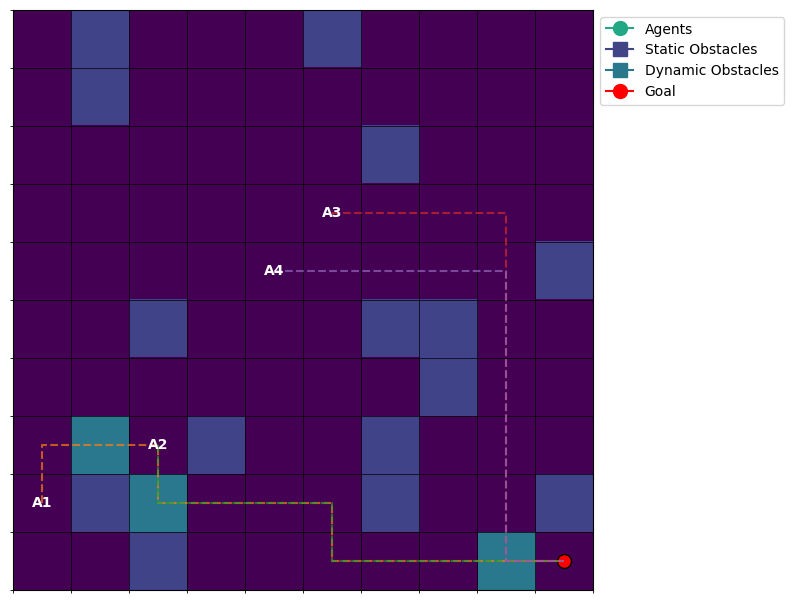

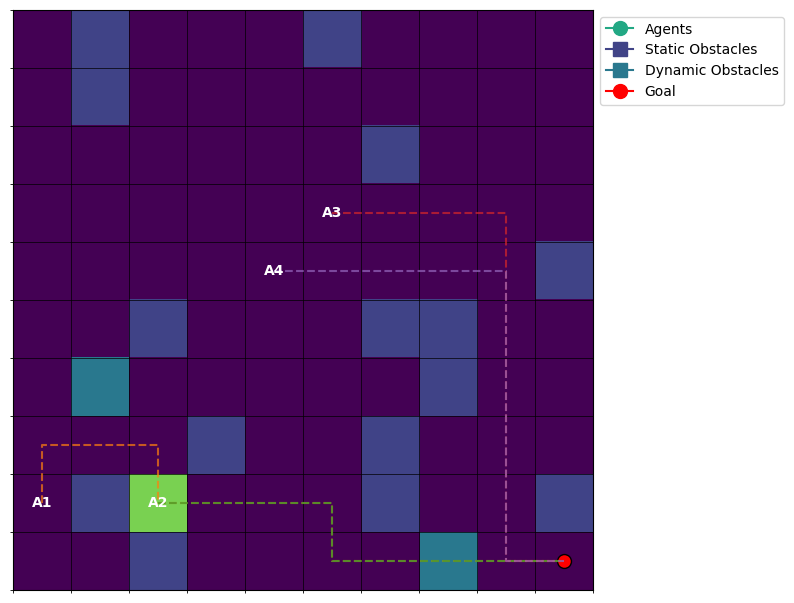

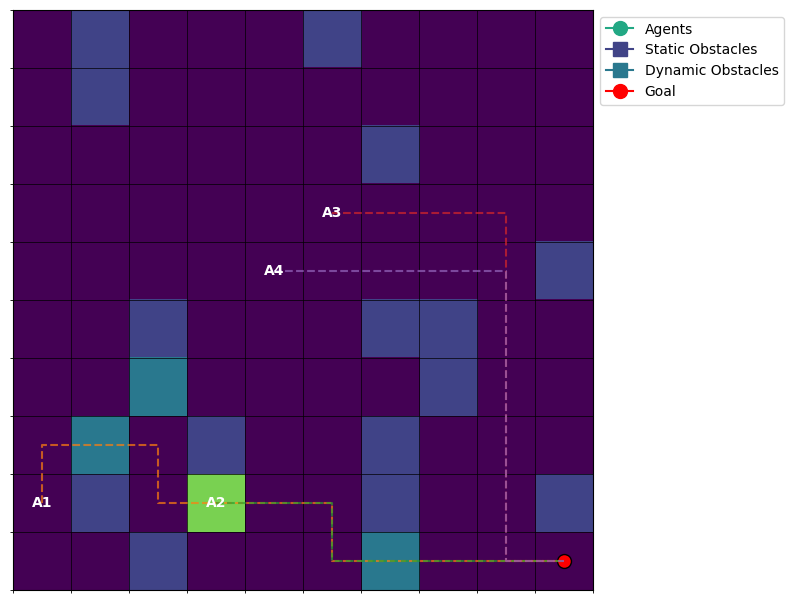

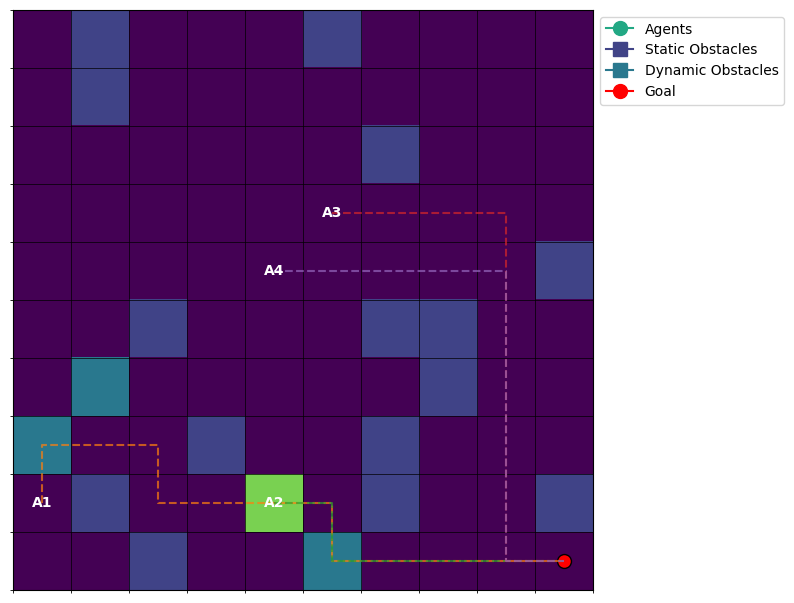

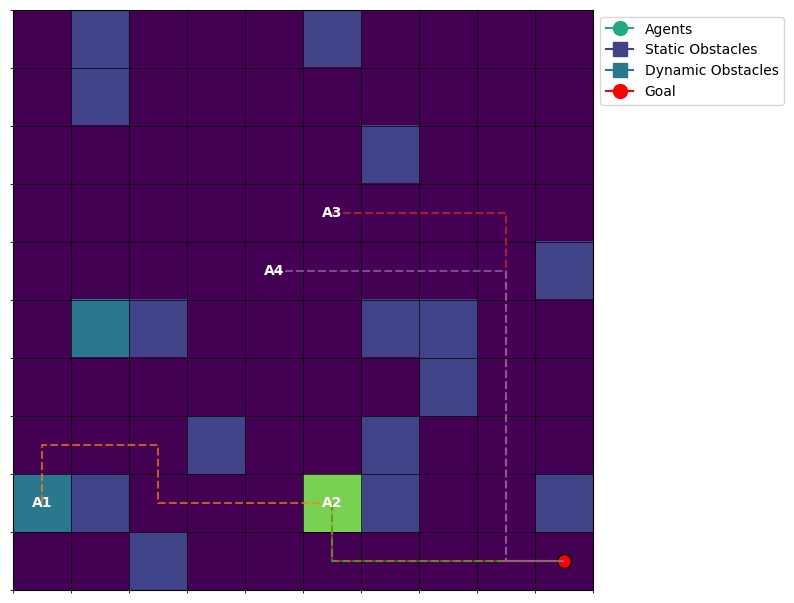

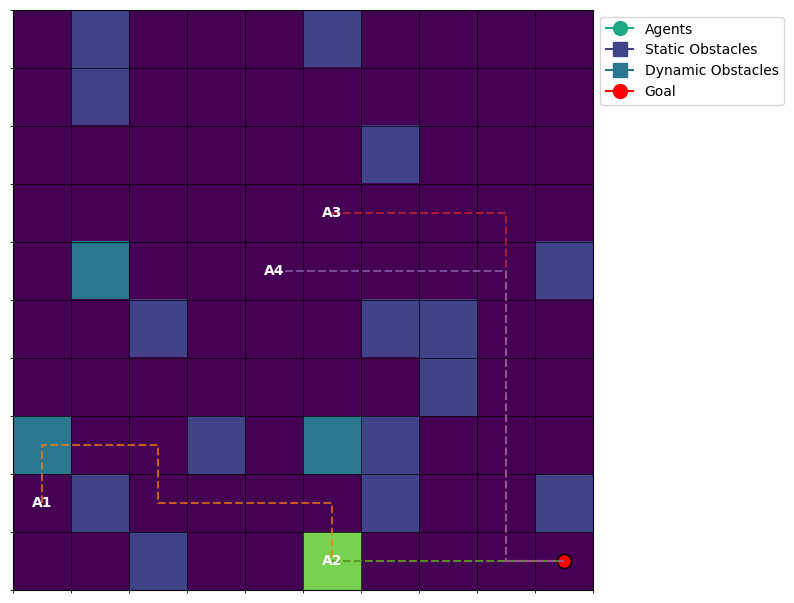

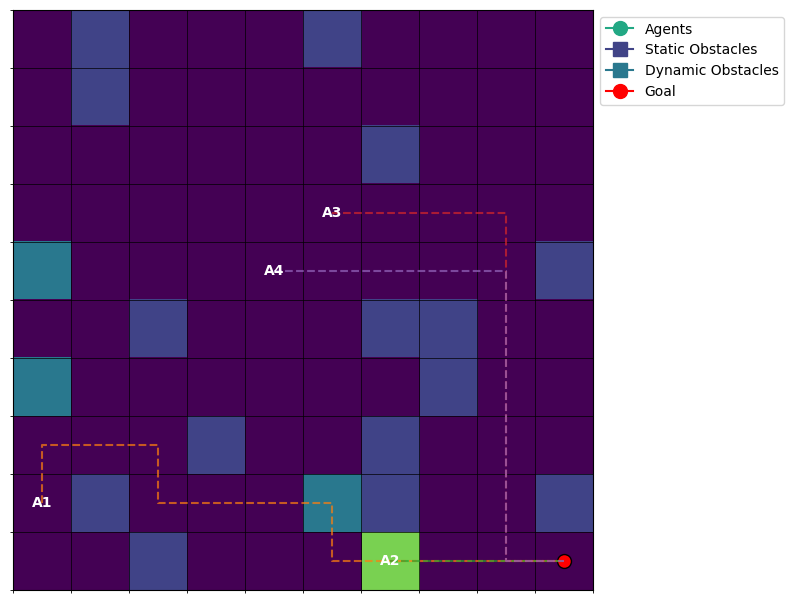

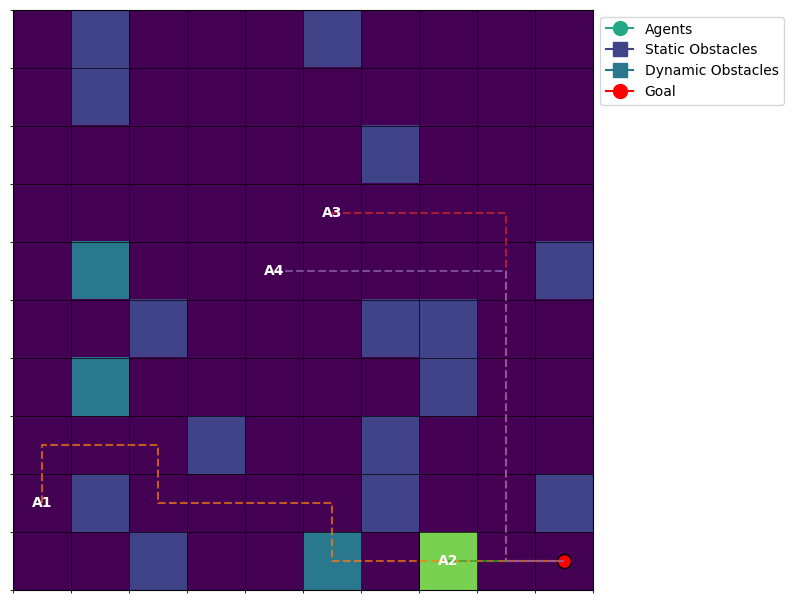

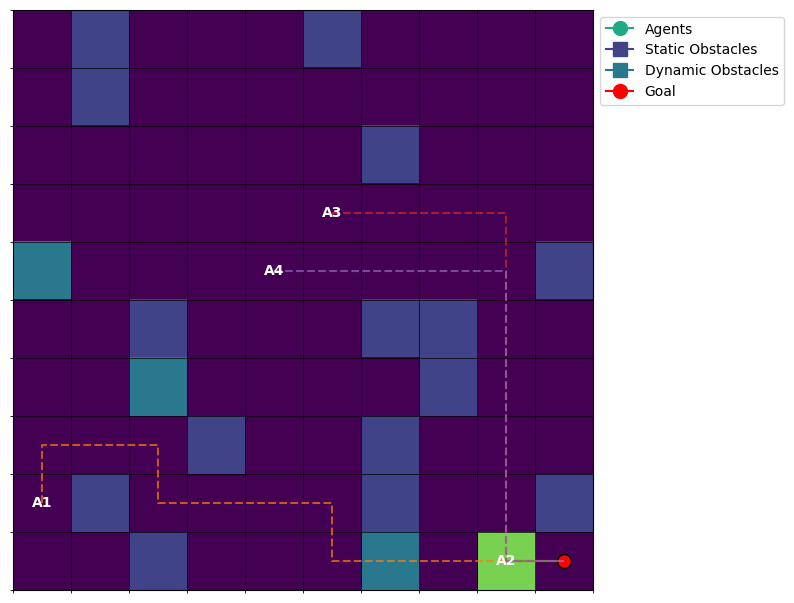

Agent 2 reached the goal!
Simulation complete.


In [21]:
import numpy as np
import random
import heapq
import matplotlib.pyplot as plt
import time


class DynamicPathPlanner(PathPlannerTest):
    def __init__(self, grid_size=(10, 10)):
        super().__init__(grid_size)
        self.agent_positions = []  # Track agent positions
        self.paths = []            # Store paths for all agents

    def update_dynamic_obstacles(self):
        """
        Simulate movement of dynamic obstacles randomly.
        """
        for i in range(len(self.dynamic_obstacles)):
            r, c = self.dynamic_obstacles[i]
            directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
            random.shuffle(directions)
            for dr, dc in directions:
                new_r, new_c = r + dr, c + dc
                if 0 <= new_r < self.grid_size[0] and 0 <= new_c < self.grid_size[1]:
                    if self.grid[new_r, new_c] == 0:  # Move to an empty cell
                        self.grid[r, c] = 0
                        self.grid[new_r, new_c] = 2
                        self.dynamic_obstacles[i] = (new_r, new_c)
                        break

    def move_agent(self, agent_idx, goal):
        """
        Move an agent one step along its path.
        """
        if self.paths[agent_idx]:
            next_step = self.paths[agent_idx][1]  # Next step in the path
            if self.grid[next_step[0], next_step[1]] in [0, 2]:  # Move if no collision
                self.grid[self.agent_positions[agent_idx][0], self.agent_positions[agent_idx][1]] = 0
                self.agent_positions[agent_idx] = next_step
                self.grid[next_step[0], next_step[1]] = 3 + agent_idx
                self.paths[agent_idx] = self.paths[agent_idx][1:]  # Remove the step
            else:
                # Stop if there's an obstacle or another agent
                self.paths[agent_idx] = []

    def replan_paths(self, goal):
        """
        Replan paths for all agents considering current grid state.
        """
        self.paths = [self.a_star(agent, goal) for agent in self.agent_positions]

    def generate_agents(self, num_agents, goal):
        """
        Randomly place agents on the grid, avoiding the goal and dynamic obstacles.
        """
        agents = []
        while len(agents) < num_agents:
            r, c = random.randint(0, self.grid_size[0] - 1), random.randint(0, self.grid_size[1] - 1)
            if self.grid[r, c] == 0 and (r, c) not in self.dynamic_obstacles and (r, c) != goal:
                agents.append((r, c))
        return agents

    def generate_dynamic_obstacles(self, interfering_paths, num_obstacles=3):
        """
        Generate dynamic obstacles to interfere with specific paths.
        """
        for path in interfering_paths:
            start, goal = path
            if start and goal:
                path_to_goal = self.a_star(start, goal)
                if len(path_to_goal) > 2:  # Ensure valid intermediate points exist
                    # Generate dynamic obstacles (up to the specified number)
                    while len(self.dynamic_obstacles) < num_obstacles:
                        r, c = random.choice(path_to_goal[1:-1])  # Place on the path excluding start and goal
                        if self.grid[r, c] == 0 and (r, c) not in self.dynamic_obstacles:
                            self.grid[r, c] = 2
                            self.dynamic_obstacles.append((r, c))
                else:
                    print(f"Warning: No valid path found between {start} and {goal}. Skipping dynamic obstacle placement.")

    def plot_grid(self, agent_positions, goal, paths):
        """
        Plot the current state of the grid with agents, obstacles, and paths.
        """
        fig, ax = plt.subplots(figsize=(8, 8))
        grid = np.copy(self.grid)
    
        # Color-coding elements in the grid
        cmap = plt.cm.get_cmap('viridis', 6)  # A colormap with distinct colors
        colors = {
            0: cmap(0),  # Empty cell
            1: cmap(1),  # Static obstacle
            2: cmap(2),  # Dynamic obstacle
            3: cmap(3),  # Agent 1
            4: cmap(4),  # Agent 2
            5: cmap(5),  # Agent 3+
        }
    
        # Create a colored grid
        colored_grid = np.zeros((*grid.shape, 4))  # Shape for RGBA
        for r in range(grid.shape[0]):
            for c in range(grid.shape[1]):
                color = colors.get(grid[r, c], (1, 1, 1, 1))  # Default white
                colored_grid[r, c] = color
    
        ax.imshow(colored_grid, interpolation='nearest')
    
        # Plot the agents, their paths, and the goal
        for idx, agent in enumerate(agent_positions):
            agent_color = cmap(3 + idx)  # Ensure each agent has a consistent color from the colormap
            ax.text(agent[1], agent[0], f'A{idx + 1}', ha='center', va='center', color='white', fontsize=10, weight='bold')
    
            # Plot paths
            if paths[idx]:
                path = np.array(paths[idx])
                ax.plot(path[:, 1], path[:, 0], linestyle='--', color=f'C{idx + 1}', alpha=0.7)
    
        # Highlight the goal
        ax.scatter(goal[1], goal[0], c='red', s=100, label='Goal', edgecolors='black')
    
        # Add grid lines
        ax.set_xticks(np.arange(-0.5, grid.shape[1], 1), minor=True)
        ax.set_yticks(np.arange(-0.5, grid.shape[0], 1), minor=True)
        ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    
        # Add a legend
        handles = [
            plt.Line2D([0], [0], marker='o', color=cmap(3), markersize=10, label='Agents'),
            plt.Line2D([0], [0], marker='s', color=cmap(1), markersize=10, label='Static Obstacles'),
            plt.Line2D([0], [0], marker='s', color=cmap(2), markersize=10, label='Dynamic Obstacles'),
            plt.Line2D([0], [0], marker='o', color='red', markersize=10, label='Goal'),
        ]
        ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1, 1))
    
        plt.tight_layout()
        plt.show()

    def simulate(self, goal, max_steps=50):
        """
        Simulate agent movement and dynamic replanning.
        """
        # Initialize paths for all agents
        self.replan_paths(goal)

        for step in range(max_steps):
            # Visualize the current grid
            self.plot_grid(self.agent_positions, goal, self.paths)
            time.sleep(1)  # Pause to observe each step

            # Update dynamic obstacles
            self.update_dynamic_obstacles()

            # Identify the closest agent to the goal
            distances = [self.manhattan_distance(agent, goal) for agent in self.agent_positions]
            closest_agent = np.argmin(distances)

            # Move the closest agent
            self.move_agent(closest_agent, goal)

            # Check if the goal is reached
            if self.agent_positions[closest_agent] == goal:
                print(f"Agent {closest_agent + 1} reached the goal!")
                break

            # Replan paths for all agents if needed
            for i, path in enumerate(self.paths):
                if not path:  # If an agent has no valid path, replan
                    self.replan_paths(goal)

        print("Simulation complete.")



# Example usage
planner = DynamicPathPlanner()

# Define grid, goal, and static obstacles
goal = (9, 9)
planner.generate_static_obstacles(num_obstacles=15, goal=goal)

# Generate agents and ensure some paths are affected
planner.agent_positions = planner.generate_agents(num_agents=4, goal=goal)

# Assign interfering paths for dynamic obstacles
interfering_paths = [(planner.agent_positions[0], goal), (planner.agent_positions[1], goal)]
planner.generate_dynamic_obstacles(interfering_paths, num_obstacles=3)

# Simulate the scenario
planner.simulate(goal)
